# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package

! pip -q install smdebug

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.42 requires botocore==1.27.42, but you have botocore 1.27.51 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.51 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [89]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import sagemaker


from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

from PIL import Image
import io
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from IPython.display import Image as ImageDisplay

import numpy as np

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [7]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -q dogImages.zip

--2022-08-14 23:58:46--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.33
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

100%[====================================>] 1,132,023,110 46.6MB/s   in 25s    

2022-08-14 23:59:11 (43.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [16]:
session = sagemaker.Session()
bucket = session.default_bucket()  
region =session.boto_region_name
role = get_execution_role()
os.environ["DEFAULT_S3_BUCKET"] = bucket



In [17]:
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/ --quiet

In [18]:
! aws s3 ls  s3://${DEFAULT_S3_BUCKET}/dogImages/test/

                           PRE 001.Affenpinscher/
                           PRE 002.Afghan_hound/
                           PRE 003.Airedale_terrier/
                           PRE 004.Akita/
                           PRE 005.Alaskan_malamute/
                           PRE 006.American_eskimo_dog/
                           PRE 007.American_foxhound/
                           PRE 008.American_staffordshire_terrier/
                           PRE 009.American_water_spaniel/
                           PRE 010.Anatolian_shepherd_dog/
                           PRE 011.Australian_cattle_dog/
                           PRE 012.Australian_shepherd/
                           PRE 013.Australian_terrier/
                           PRE 014.Basenji/
                           PRE 015.Basset_hound/
                           PRE 016.Beagle/
                           PRE 017.Bearded_collie/
                           PRE 018.Beauceron/
                           PRE 019.Bedlington_terrier/
 

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [19]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges={
    "lr":ContinuousParameter(0.001, 0.01),
    "batch_size":CategoricalParameter([16,32,128]),
    "epochs": IntegerParameter(3,6)
}

In [20]:
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://'+bucket+'/output/'

In [40]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point='hpo.py',
    py_version='py36',
    base_job_name='hpo_tuning',
    role=role,
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.large')

In [41]:

objective_metric_name = "average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "average test accuracy", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [42]:
# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type)


In [43]:

train_data = "s3://{}/{}/".format(bucket, "dogImages")
output_directory = "s3://{}/{}/".format(bucket, "output")
model_directory = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= train_data
os.environ['SM_MODEL_DIR']= model_directory
os.environ['SM_OUTPUT_DATA_DIR']= output_directory

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({'train' : train_data},wait=True)  # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [45]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-08-15 02:50:25 Starting - Preparing the instances for training
2022-08-15 02:50:25 Downloading - Downloading input data
2022-08-15 02:50:25 Training - Training image download completed. Training in progress.
2022-08-15 02:50:25 Uploading - Uploading generated training model
2022-08-15 02:50:25 Completed - Training job completed


{'_tuning_objective_metric': '"average test accuracy"',
 'batch_size': '"128"',
 'epochs': '3',
 'lr': '0.00604276152932198',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning-2022-08-15-01-57-55-705"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-979233489196/hpo_tuning-2022-08-15-01-57-55-705/source/sourcedir.tar.gz"'}

In [62]:
hyperparameters = {"batch_size": (best_estimator.hyperparameters()['batch_size']),
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": best_estimator.hyperparameters()['epochs']}


In [63]:
print(hyperparameters)

{'batch_size': '"128"', 'lr': '0.00604276152932198', 'epochs': '3'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [66]:
hyperparameters = {"batch_size": "128", "epochs":"3", "lr": "0.00604276152932198"}


In [69]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

# Profiler Setup
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1))
# Debugger Setup
debugger_config=DebuggerHookConfig(collection_configs=collection_configs)

In [75]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({'train' : train_data},wait=True)

2022-08-15 04:27:31 Starting - Starting the training job...
2022-08-15 04:27:47 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-08-15 04:28:53 Downloading - Downloading input data............
2022-08-15 04:30:58 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-15 04:31:00,049 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-15 04:31:00,052 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-08-15 04:31:00,062 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-15 04:31:00,069 sagemaker_pytorch_container.training IN

In [79]:
# TODO: Plot a debugging output.
training_job = estimator.latest_training_job.name
print("Training jobname: ".format(training_job))

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)



Training jobname: 
[2022-08-15 05:05:19.497 ip-172-16-120-128.ec2.internal:6940 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-979233489196/pytorch-training-2022-08-15-04-27-30-969/debug-output
[2022-08-15 05:05:21.767 ip-172-16-120-128.ec2.internal:6940 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-08-15 05:05:22.802 ip-172-16-120-128.ec2.internal:6940 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.re

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
- Import package issues which resolved in the notebook first by doing `pip uninstall Werkzeug jinja2 && pip install jinja2==3.0 Werkzeug==2.0.0`
- Observed error in model execution and updated the train_model.py line number according to the error log

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?
- In case there was an error in the parameter passed then I couuld observe the log and verify

In [80]:
profile_output = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
profile_output

's3://sagemaker-us-east-1-979233489196/pytorch-training-2022-08-15-04-27-30-969/rule-output'

In [81]:
# TODO: Display the profiler output

! aws s3 ls {profile_output} --recursive
! aws s3 cp {profile_output} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

2022-08-15 04:55:25     375447 pytorch-training-2022-08-15-04-27-30-969/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-08-15 04:55:25     223379 pytorch-training-2022-08-15-04-27-30-969/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-08-15 04:55:20        192 pytorch-training-2022-08-15-04-27-30-969/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-08-15 04:55:20        200 pytorch-training-2022-08-15-04-27-30-969/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-08-15 04:55:20       1741 pytorch-training-2022-08-15-04-27-30-969/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-08-15 04:55:20        127 pytorch-training-2022-08-15-04-27-30-969/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-08-15 04:55:20        199 pytorch-training-2022-08-15-04-27-30-969/rule-output/ProfilerReport/profiler-output/profiler-re

## Model Deploying

In [83]:
modellocation=estimator.model_data

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

In [84]:
# TODO: Deploy your model to an endpoint


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )



In [98]:
# TODO: Add your deployment configuration like instance type and number of instances
pytorch_model = PyTorchModel(model_data=modellocation, role=role, entry_point='inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) 

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large") 

-------!

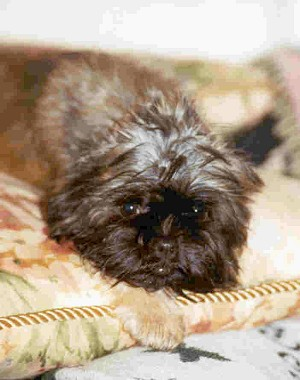

In [99]:


# TODO: Run an prediction on the endpoint
buf = io.BytesIO()
Image.open("./dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg").save(buf, format="JPEG")
ImageDisplay(image)

In [100]:
# TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(buf.getvalue())

In [101]:
np.argmax(response, 1)

array([37])

In [102]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()